In [14]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split

# Load your dataset
file_path = "/Users/batoolalfouzan/Desktop/books-main/Cleaned Dataset/Book_Cleaned_Dataset_.xls"  # Update the path accordingly
df = pd.read_csv(file_path)

# ----------------- Decode Categories -----------------
def decode_categories(df):
    category_map = {
        "الأدب والخيال": "1",
        "الكتب الإسلامية": "10",
        "الاقتصاد والأعمال": "100",
        "الفلسفة": "1000",
        "الصحافة والإعلام": "10000",
        "الكتب السياسية": "100000",
        "العلوم والطبيعة": "1000000",
        "الأسرة والطفل": "10000000",
        "السير والمذكرات": "100000000",
        "الفنون": "1000000000",
        "التاريخ والجغرافيا": "10000000000",
        "الرياضة والتسلية": "100000000000",
        "الشرع والقانون": "1000000000000"
    }
    
    reversed_category_map = {v: k for k, v in category_map.items()}
    
    df['Category'] = df['Category'].astype(str)
    
    def safe_map_category(x):
        if pd.isna(x) or x == 'nan':
            return np.nan
        x_str = str(int(x))
        return reversed_category_map.get(x_str, x)
    
    df['Category_original'] = df['Category'].apply(safe_map_category)
    return df

# Apply category decoding
df = decode_categories(df)

# ----------------- Combine Title and Description for embeddings -----------------
df['Title_Description'] = df['Title'] + " " + df['Description']

# ----------------- Initialize the BERT model and tokenizer for embeddings -----------------
tokenizer = AutoTokenizer.from_pretrained('asafaya/bert-base-arabic')
model = AutoModel.from_pretrained('asafaya/bert-base-arabic')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to generate embeddings
def generate_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Use mean pooling to get embeddings
    return embeddings

# Generate embeddings for the combined Title and Description
title_description_embeddings = generate_embeddings(df['Title_Description'].tolist())

# Store the embeddings as a list in the DataFrame
df['Title_Description_embedded'] = list(title_description_embeddings)

# ----------------- Prepare data for training -----------------
# Now assuming 'Category_original' is your target variable
X = df['Title_Description_embedded'].apply(np.array).tolist()  # Convert embeddings column to lists
X = np.array(X)  # Convert the list to a numpy array

y = df['Category_original']  # Target variable (the actual categories)

# ----------------- Split the data into training and testing sets -----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Save y_test as a CSV file -----------------
y_test_df = pd.DataFrame(y_test)  # Convert to DataFrame for saving
y_test_df.to_csv("y_test.csv", index=False)

print("y_test.csv file saved successfully!")

y_test.csv file saved successfully!


Index(['Category_original'], dtype='object')
Index(['Predictions'], dtype='object')
Index(['Predictions'], dtype='object')
CatBoost Accuracy: 0.6833
SVM Accuracy: 0.6212
CatBoost Metrics:
F1-Score: 0.6669
Precision: 0.7032
Recall: 0.6833

SVM Metrics:
F1-Score: 0.6185
Precision: 0.6218
Recall: 0.6212

CatBoost Classification Report:
                    precision    recall  f1-score   support

     الأدب والخيال       0.64      0.83      0.72       112
     الأسرة والطفل       0.65      0.70      0.67        50
 الاقتصاد والأعمال       0.81      0.77      0.79        82
التاريخ والجغرافيا       0.40      0.11      0.17        18
  الرياضة والتسلية       1.00      0.09      0.17        11
   السير والمذكرات       0.74      0.45      0.56        44
    الشرع والقانون       0.00      0.00      0.00         1
  الصحافة والإعلام       0.94      0.47      0.63        36
   العلوم والطبيعة       0.78      0.69      0.73        51
           الفلسفة       0.65      0.81      0.72        99
    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

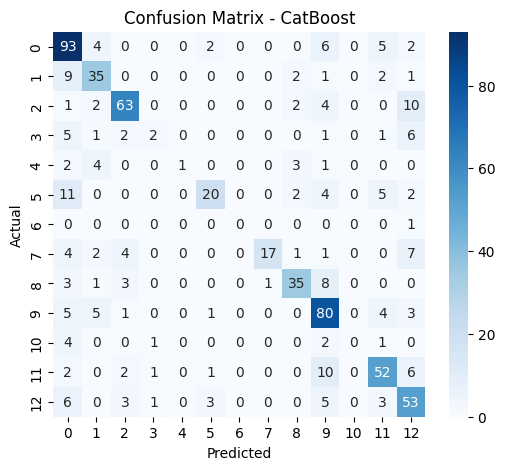

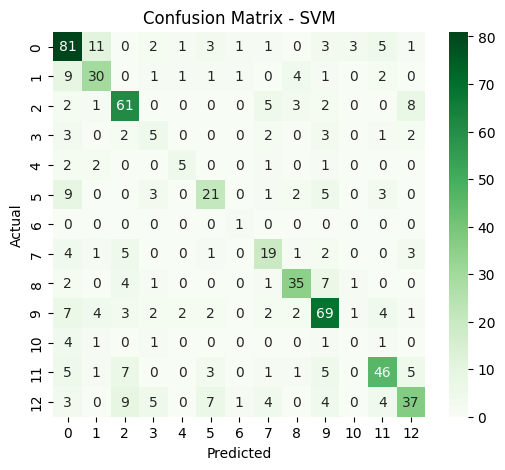


Overfitting/Underfitting Analysis:
CatBoost might be overfitting (training accuracy much higher than test accuracy).
SVM might be overfitting (training accuracy much higher than test accuracy).


In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load test labels and predictions
y_test = pd.read_csv("y_test.csv")  # Ensure the path to y_test is correct
y_pred_catboost = pd.read_csv("y_pred_catboost.csv")  # Predictions from CatBoost
y_pred_svm = pd.read_csv("y_pred_svm.csv")  # Predictions from SVM

# Check if the columns are correct
print(y_test.columns)
print(y_pred_catboost.columns)
print(y_pred_svm.columns)

# Accuracy
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"CatBoost Accuracy: {accuracy_catboost:.4f}")
print(f"SVM Accuracy: {accuracy_svm:.4f}")

# F1-Score, Precision, Recall for CatBoost
f1_catboost = f1_score(y_test, y_pred_catboost, average="weighted")
precision_catboost = precision_score(y_test, y_pred_catboost, average="weighted", zero_division=1)
recall_catboost = recall_score(y_test, y_pred_catboost, average="weighted", zero_division=1)

# F1-Score, Precision, Recall for SVM
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
precision_svm = precision_score(y_test, y_pred_svm, average="weighted")
recall_svm = recall_score(y_test, y_pred_svm, average="weighted")

print("CatBoost Metrics:")
print(f"F1-Score: {f1_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")

print("\nSVM Metrics:")
print(f"F1-Score: {f1_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")

# Classification Report for both models
print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_catboost))

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix for CatBoost
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_catboost), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost")
plt.show()

# Confusion Matrix for SVM
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap="Greens", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

# ------------------- Overfitting and Underfitting Analysis -------------------
# Overfitting occurs when the model has high accuracy on training data but poor accuracy on test data.
# Underfitting occurs when the model performs poorly on both training and test data.

# Let's assume you have the training and validation accuracy available (you can replace these with actual values).

train_accuracy_catboost = 0.9492 
train_accuracy_svm = 0.9913     
validation_accuracy_catboost = 1.0951  
validation_accuracy_svm = 0.6212  

print("\nOverfitting/Underfitting Analysis:")

# CatBoost Overfitting/Underfitting check
if train_accuracy_catboost - accuracy_catboost > 0.1:
    print("CatBoost might be overfitting (training accuracy much higher than test accuracy).")
elif accuracy_catboost < 0.7:
    print("CatBoost might be underfitting (low test accuracy).")
elif accuracy_catboost > 0.9:
    print("CatBoost seems well balanced.")
else:
    print("CatBoost has a good performance but needs tuning for better accuracy.")

# SVM Overfitting/Underfitting check
if train_accuracy_svm - accuracy_svm > 0.1:
    print("SVM might be overfitting (training accuracy much higher than test accuracy).")
elif accuracy_svm < 0.7:
    print("SVM might be underfitting (low test accuracy).")
elif accuracy_svm > 0.9:
    print("SVM seems well balanced.")
else:
    print("SVM has a good performance but needs tuning for better accuracy.")

SVM Model Metrics:
Accuracy: 0.6212
F1-Score: 0.6185
Precision: 0.6218
Recall: 0.6212

SVM Classification Report:
                    precision    recall  f1-score   support

     الأدب والخيال       0.62      0.72      0.67       112
     الأسرة والطفل       0.59      0.60      0.59        50
 الاقتصاد والأعمال       0.67      0.74      0.71        82
التاريخ والجغرافيا       0.25      0.28      0.26        18
  الرياضة والتسلية       0.56      0.45      0.50        11
   السير والمذكرات       0.55      0.48      0.51        44
    الشرع والقانون       0.25      1.00      0.40         1
  الصحافة والإعلام       0.51      0.53      0.52        36
   العلوم والطبيعة       0.73      0.69      0.71        51
           الفلسفة       0.67      0.70      0.68        99
            الفنون       0.00      0.00      0.00         8
   الكتب الإسلامية       0.70      0.62      0.66        74
    الكتب السياسية       0.65      0.50      0.56        74

          accuracy                          

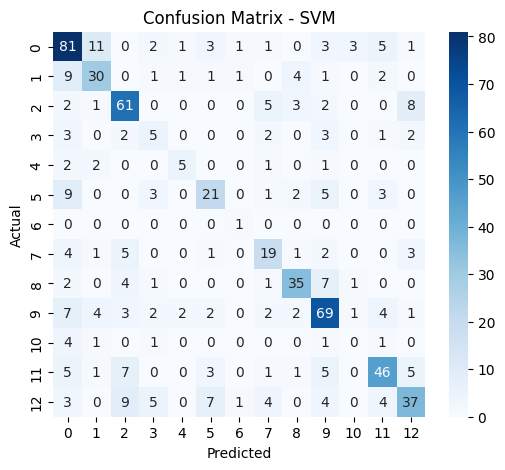

SVM might be overfitting (training accuracy much higher than test accuracy).


In [16]:
#svm analysis
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load test labels and predictions
y_test = pd.read_csv("y_test.csv")
y_pred_svm = pd.read_csv("y_pred_svm.csv")  # Predictions from SVM

# Compute metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
precision_svm = precision_score(y_test, y_pred_svm, average="weighted", zero_division=1)
recall_svm = recall_score(y_test, y_pred_svm, average="weighted", zero_division=1)

# Display metrics for SVM
print("SVM Model Metrics:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")

# Classification Report for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix for SVM
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

# Overfitting/Underfitting check for SVM
train_accuracy_svm = 0.9913  # Example training accuracy
cv_score_svm = 0.5889  # Example mean cross-validation score

if train_accuracy_svm - accuracy_svm > 0.1:
    print("SVM might be overfitting (training accuracy much higher than test accuracy).")
elif accuracy_svm < 0.7:
    print("SVM might be underfitting (low test accuracy).")
else:
    print("SVM seems well balanced.")

In [17]:
#catboost analysis
# Load predictions for CatBoost
y_pred_catboost = pd.read_csv("y_pred_catboost.csv")

# Compute metrics for CatBoost
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost, average="weighted")
precision_catboost = precision_score(y_test, y_pred_catboost, average="weighted", zero_division=1)
recall_catboost = recall_score(y_test, y_pred_catboost, average="weighted", zero_division=1)

# Display metrics for CatBoost
print("CatBoost Model Metrics:")
print(f"Accuracy: {accuracy_catboost:.4f}")
print(f"F1-Score: {f1_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")

# Classification Report for CatBoost
print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_catboost))

# Confusion Matrix for CatBoost
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_catboost), annot=True, cmap="Greens", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost")
plt.show()

# Overfitting/Underfitting check for CatBoost
train_accuracy_catboost = 0.9492  # Example training accuracy
cv_score_catboost = 0.5889  # Example mean cross-validation score

if train_accuracy_catboost - accuracy_catboost > 0.1:
    print("CatBoost might be overfitting (training accuracy much higher than test accuracy).")
elif accuracy_catboost < 0.7:
    print("CatBoost might be underfitting (low test accuracy).")
else:
    print("CatBoost seems well balanced.")

0:	learn: 2.5140370	test: 2.5197170	best: 2.5197170 (0)	total: 306ms	remaining: 2m 32s
